In [1]:
import os
import argparse
import logging
import sys

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

os.chdir(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))))

from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA
import numpy as np
import json

from sklearn.manifold import TSNE
from collections import deque
import math

In [2]:
rnn = "lstm"

In [3]:
train_path = "data/palindrome_rand/correction_single_Ctype4_error_rate_5/data_train.txt"
log_path = "log/pth/palindrome_rand_error_rate_5_hard_attn_" + rnn + "_lenemb_model_save.pth"
config_path = "models/config.json"

In [4]:
LOG_FORMAT = '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, "info".upper()))

In [5]:
# Prepare dataset
src = fields.SourceField()
tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)

In [6]:
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

In [7]:
# Prepare loss
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

'''
config = { "max_len": 102,
            "embedding_size": 5,
            "hidden_size": 200,
            "input_dropout_p": 0,
           "dropout_p": 0,
            "n_layers": 1,
           "bidirectional": False,
           "rnn_cell": "lstm",
            "embedding": None,
            "update_embedding": True,
           "get_context_vector": False,
           "use_attention": true,
           "attn_layers": 1,
            "position_embedding": None }
'''

optimizer = "Adam"
seq2seq = None
config_json = open(config_path).read()
config = json.loads(config_json)
config["max_len"] = max_len
config["rnn_cell"] = rnn
config["position_embedding"] = "Length"
config["hard_attn"] = True

/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Initialize model

In [8]:
# Initialize model
seq2seq = Seq2seq(config, len(src.vocab), len(tgt.vocab), tgt.sos_id, tgt.eos_id)

if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

seq2seq.load_state_dict(torch.load(log_path))
seq2seq.eval()

predictor = Predictor(seq2seq, input_vocab, output_vocab)

# Answer function

In [9]:
def answer_function(data):
    results = []
    words = data.split("#")
    comp = []
    for word in words:
        result = ""
        m = int(len(word)/2)
        for i in range(0,m):
            result += "0"
            comp.append(word[i])
        if len(word)%2 != 0:
            result += "0"
            m += 1
        for i in range(m,len(word)):
            w = comp.pop()
            if word[i] != w:
                if w == "a":
                    result += "1"
                elif w == "b":
                    result += "2"
                elif w == "c":
                    result += "3"
                elif w == "d":
                    result += "4"
                else:
                    result += "0"
            else:
                result += "0"
                
        results.append(result)

    return " ".join("0".join(results))

# Step function

In [10]:
def step_function(x):
    
    if x > 0:
        if x < 0.5:
            return 0
        else:
            return 1
    else:
        if x > -0.5:
            return 0
        else:
            return -1

# Predict

input : c b b c c a a a b d d d c d c d c d b a b a c b c b b c a d d b d c d b d c d d d b a a a c b b b c


/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Answer: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 2 1 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 3 0 0 0
Luong : 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 2 1 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 3 0 0 0 <eos>


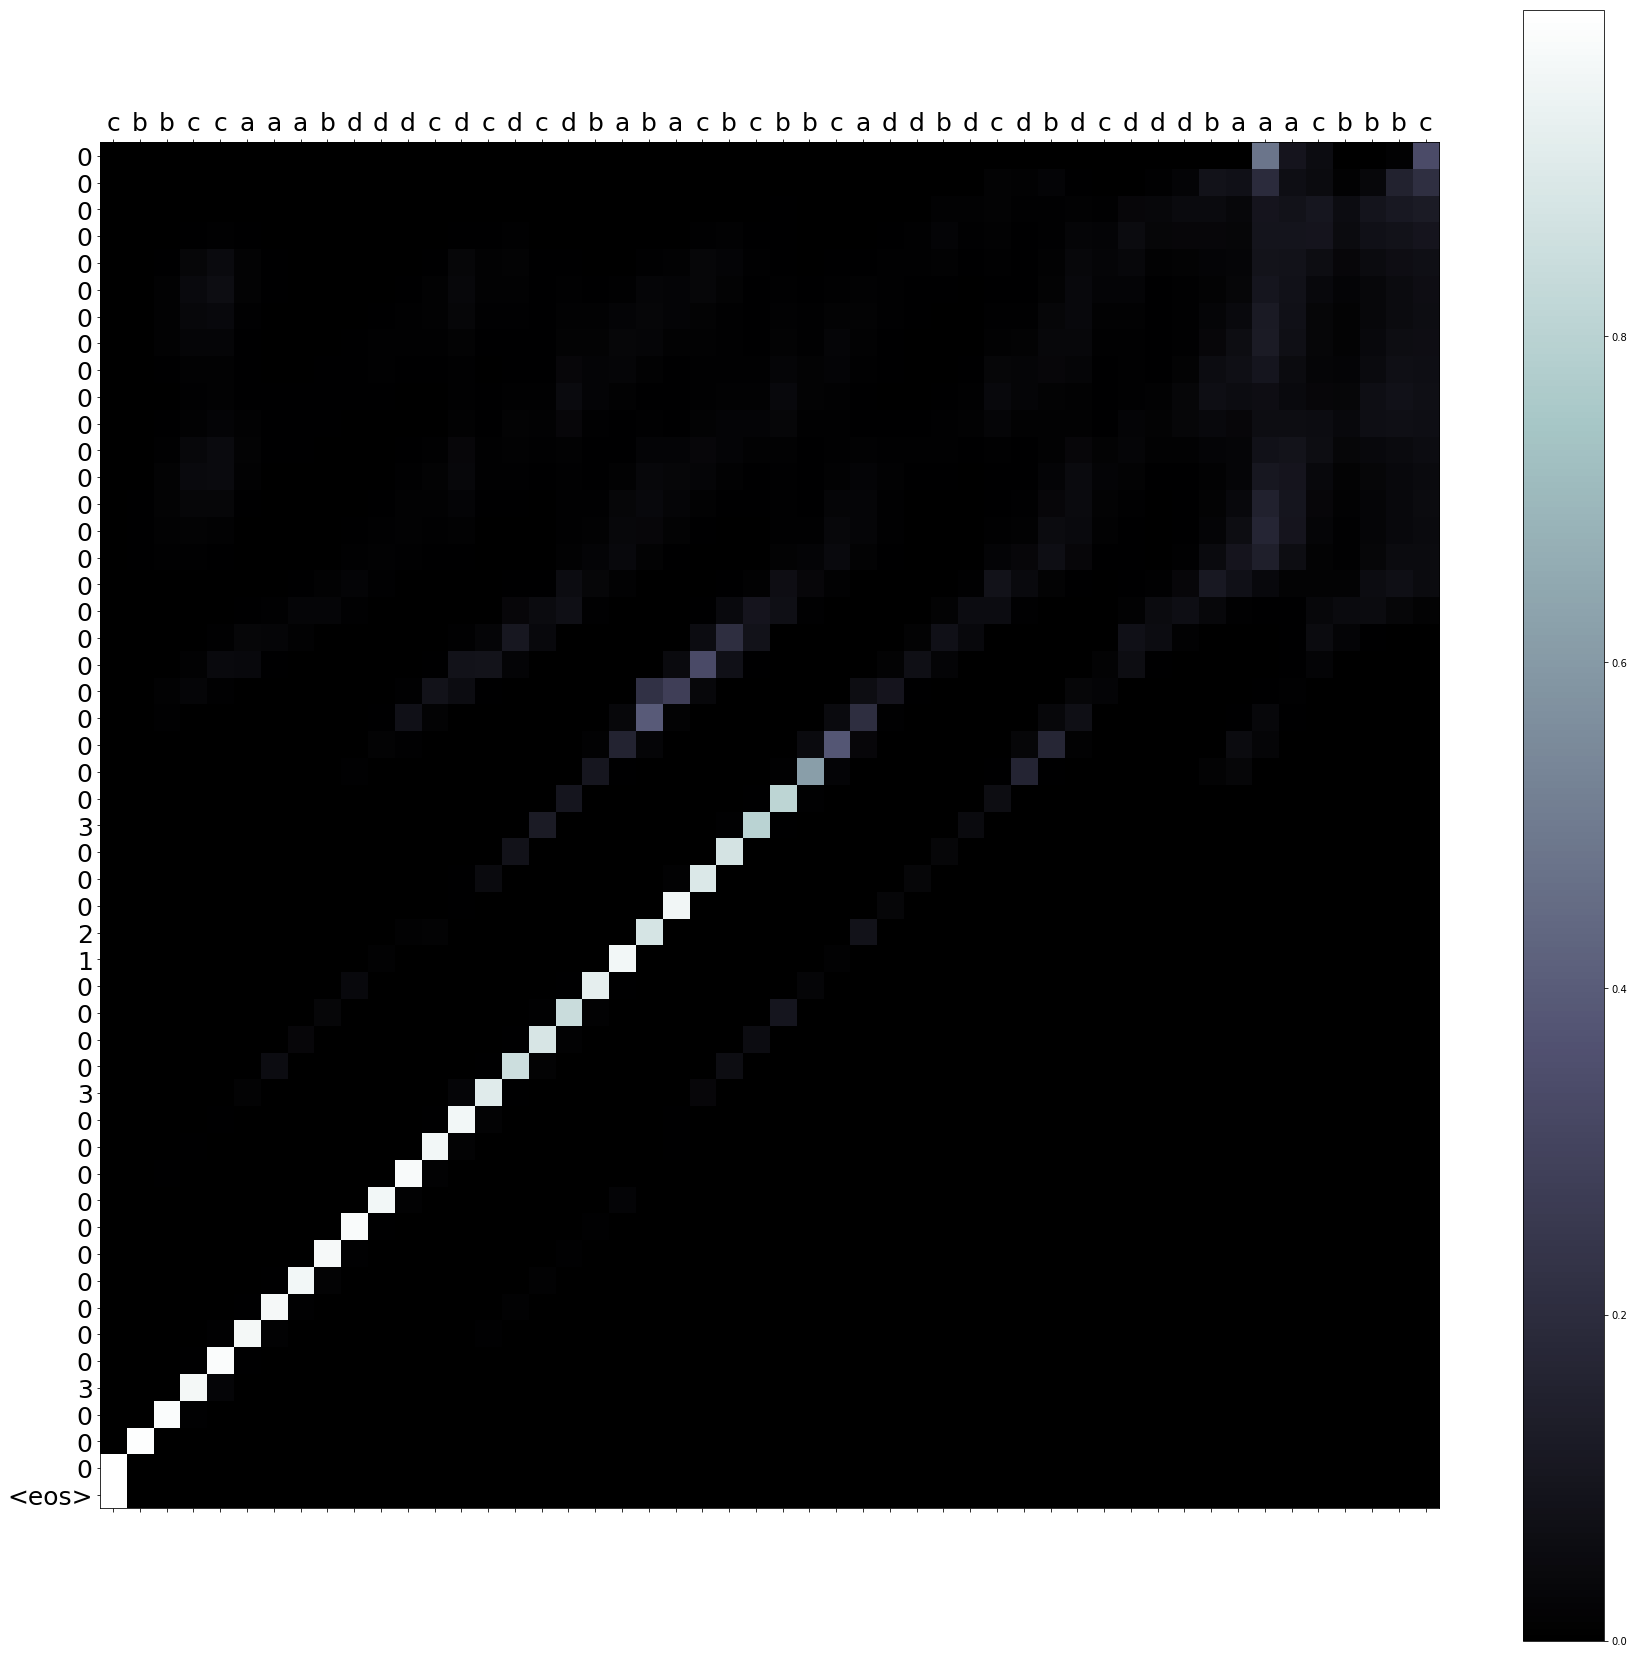

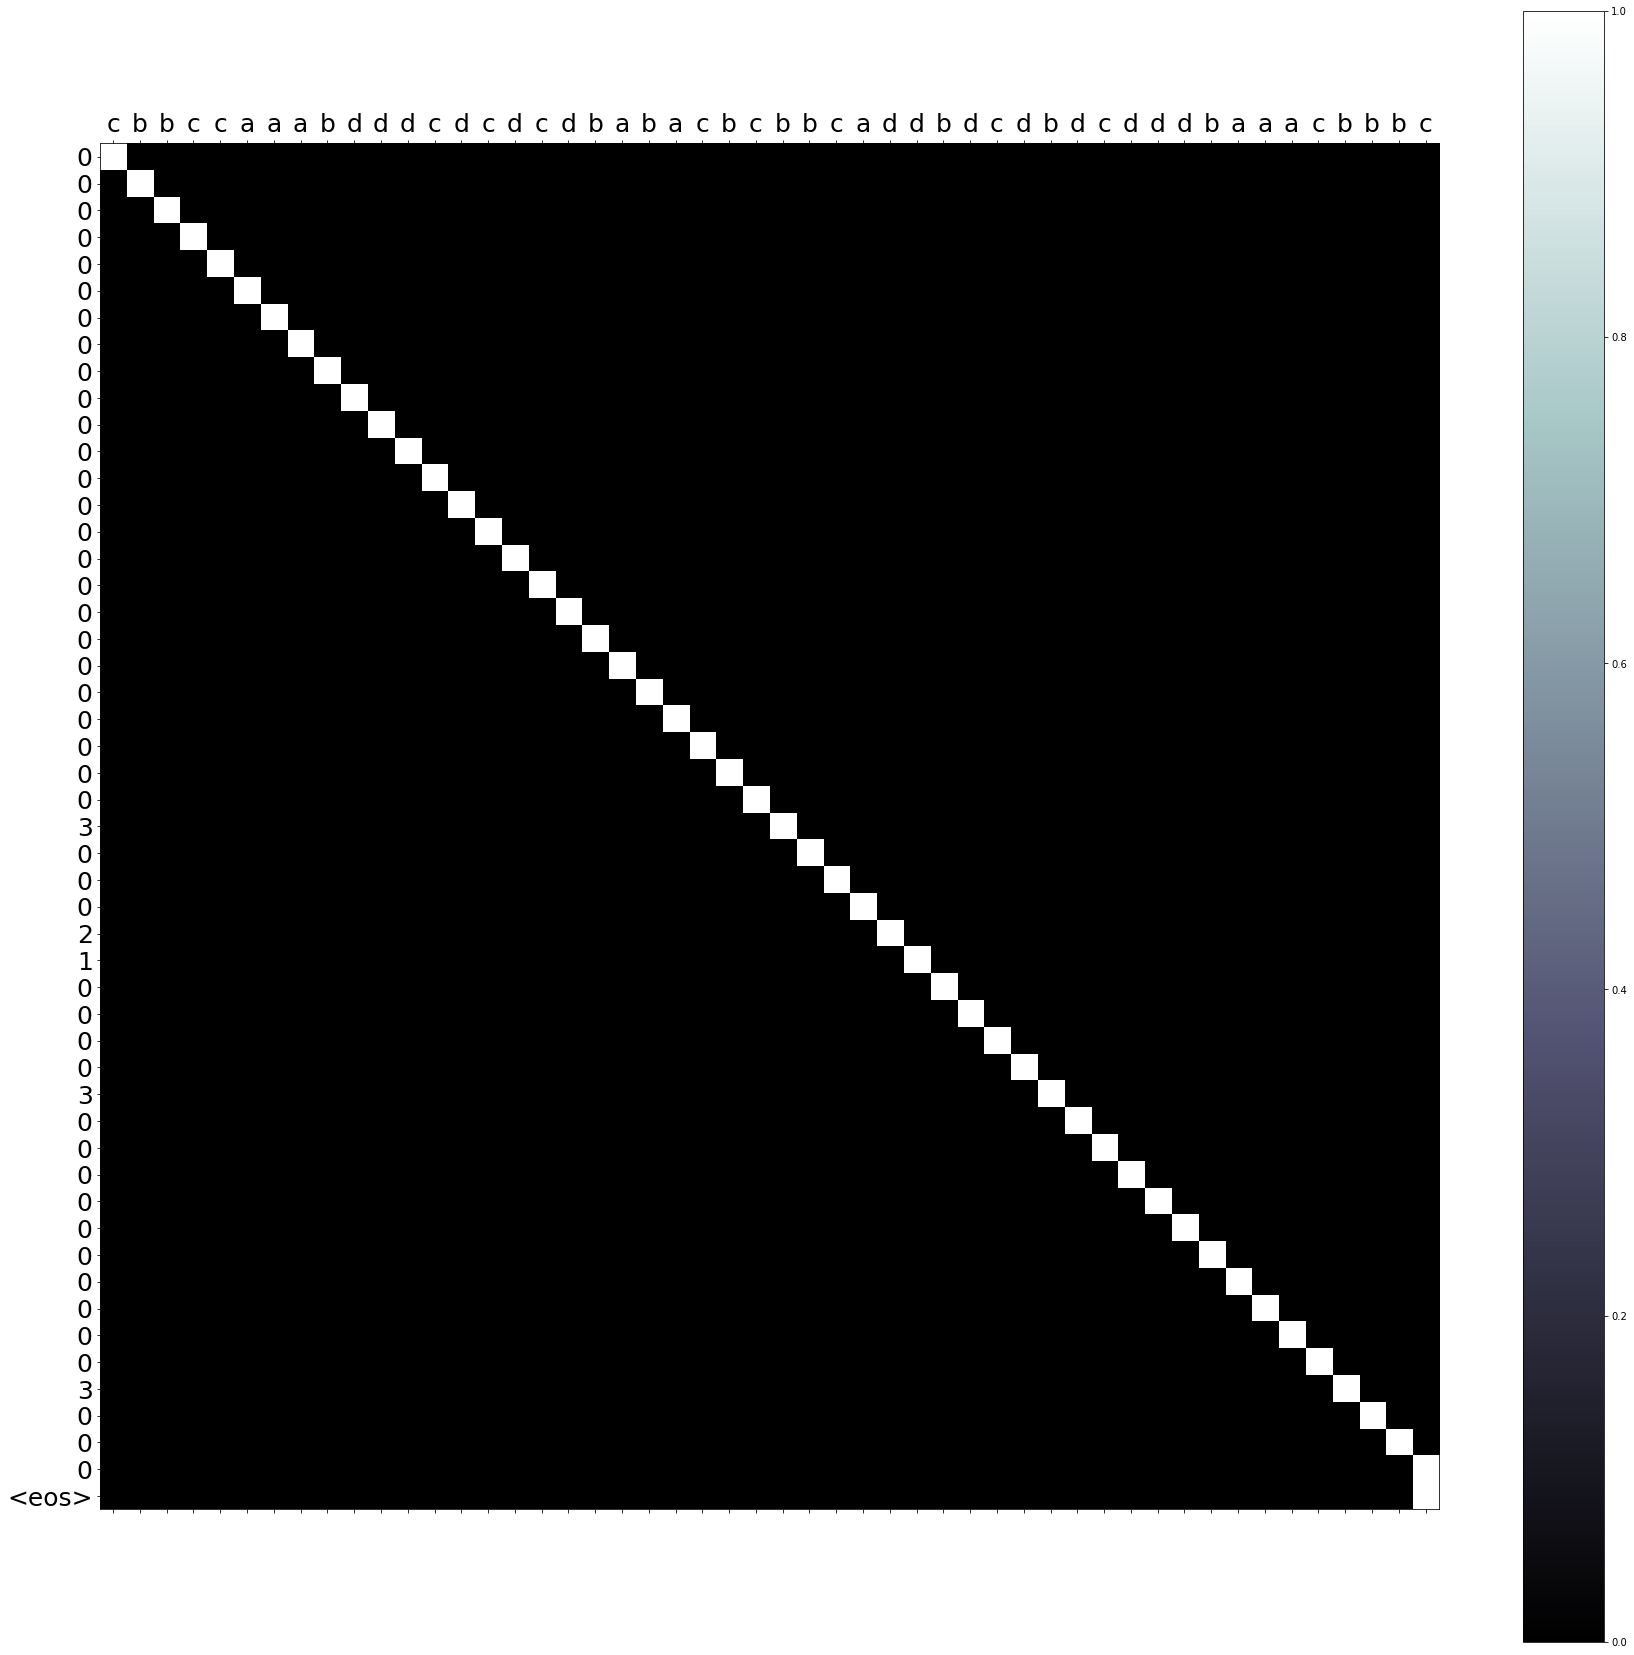

In [11]:
try:
    while True:
        seq_str = input("input : ")
        seq = "".join(seq_str.strip().split())
        tgt_seq, tgt_att_list, encoder_outputs, _ = predictor.predict(seq)
        print("Answer: " + answer_function(seq))
        print("Luong : " + " ".join(tgt_seq))
        
        # attention visualize
        for att in tgt_att_list:
            fig = plt.figure(figsize=(30,30))
            ax = fig.add_subplot(111)
            cax = ax.matshow(att, cmap='bone')
            fig.colorbar(cax)

            ax.set_xticklabels([''] + list(seq), fontsize=25)
            ax.set_yticklabels([''] + tgt_seq, fontsize=25)

            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

            plt.show()
        
except KeyboardInterrupt:
    pass